## Dominik Adamczyk
### Mownit Lab4 rozwiązania

1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

In [137]:
function lagrange_interpolation(x, y)
    function polynomial(z)
        n = length(x)
        p = 0.0
        for i = 1:n
            l = 1.0
            for j = 1:n
                if j != i
                    l *= (z - x[j]) / (x[i] - x[j])
                end
            end
            p += y[i] * l
        end
        return p
    end
    return polynomial
end

lagrange_interpolation (generic function with 1 method)

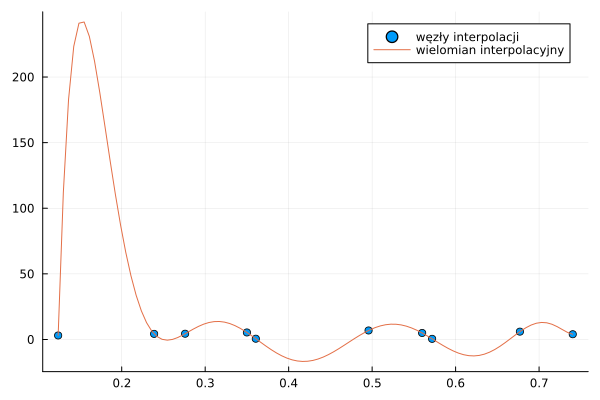

In [138]:
using Random, Plots
# liczba punktów interpolacji
n = 10

# wygeneruj losowe wartości x i y
x = rand(n)
y = rand(n) * 10

# utwórz funkcję wielomianu interpolacyjnego
p_lagrange = lagrange_interpolation(x, y)

# wygeneruj punkty do interpolacji
z = collect(range(minimum(x), maximum(x), length=100))

# policz wartości funkcji interpolowanej i wielomianu interpolacyjnego w punktach z
p_values_lagrange = p_lagrange.(z)

# narysuj wykresy funkcji interpolowanej i wielomianu interpolacyjnego
scatter(x, y, label="węzły interpolacji")
plot!(z, p_values_lagrange, label="wielomian interpolacyjny")

2. Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

In [139]:
function horner(coefficients, knots, at)
    n = length(knots)
    b = coefficients[n]
    for i in n-1:-1:1
        b = coefficients[i] + (at - knots[i]) * b
    end
    return b
end

horner (generic function with 1 method)

In [140]:
function  NewtonInterpolation(x, y)
    n = length(x)
    F = zeros(n, n)
    F[:, 1] .= y
    # display(F)
    for j in 2:n
        # println(j)
        for i in j:n
            # println(i)
            F[i, j] = (F[i, j-1] - F[i-1, j-1]) / (x[i] - x[i-j+1])
        end
        # display(F)
    end
    newt = [F[i, i] for i in 1:n]
    newt_object = point -> horner(newt, x, point)
    return newt_object
end

NewtonInterpolation (generic function with 1 method)

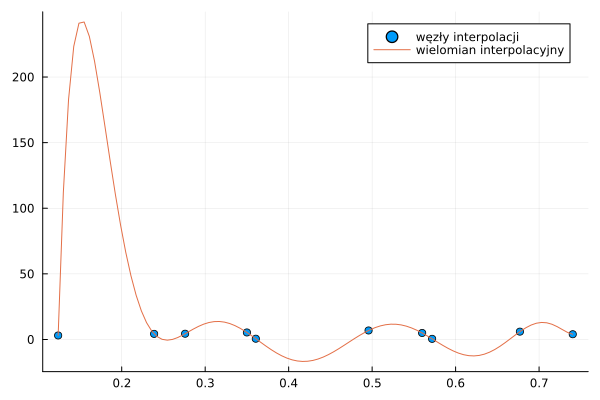

In [141]:
p_newton = NewtonInterpolation(x, y)

p_values_newton = p_newton.(z)

scatter(x, y, label="węzły interpolacji")
plot!(z, p_values_newton, label="wielomian interpolacyjny")

3. Zastosować interpolację wielomianową z pakietu Polynomials do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

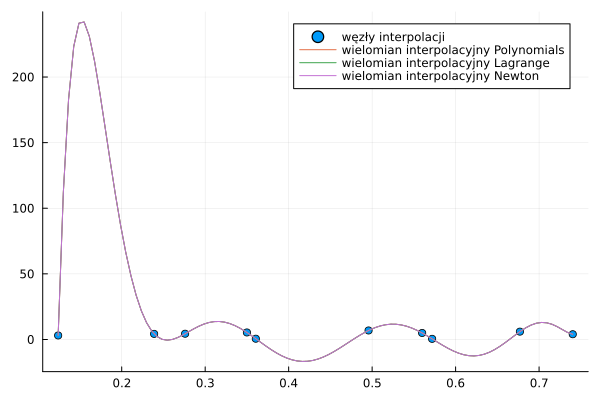

In [142]:
using Polynomials

p_polynomials = fit(x, y)

p_values_polynomials = p_polynomials.(z)

scatter(x, y, label="węzły interpolacji")
plot!(z, p_values_polynomials, label="wielomian interpolacyjny Polynomials")
plot!(z, p_values_lagrange, label="wielomian interpolacyjny Lagrange")
plot!(z, p_values_newton, label="wielomian interpolacyjny Newton")

Wszystkie krzywe się pokrywają, co jest zgodne z twierdzeniem, że istnieje dokładnie jeden wielomian n-1 stopnia przechodzący przez n punktów. Każda z przedstawionych metod wylicza ten wielomian

4. Porównać metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonać pomiaru 10 razy i policzyć wartość średnią oraz oszacować błąd pomiaru za pomocą odchylenia standardowego; wyniki przedstawić na wykresach. <b>(2 pkt)</b>

In [143]:
function interpolation_points(n)
    x = rand(n)
    y = rand(n)
    return x, y
end

interpolation_points (generic function with 1 method)

In [144]:
function measure_lagrange(x, y, df, repeats=1)
    time = 0
    for _ in 1:repeats
        func = lagrange_interpolation(x, y)
        time += @elapsed lagrange_interpolation(x, y)
        time += @elapsed func.(z)
    end
    push!(df, ["lagrange", length(x), time, 0])
end

function measure_newton(x, y, df, repeats=1)
    pol_time = 0
    point_time = 0
    for _ in 1:repeats
        pol_time += @elapsed NewtonInterpolation(x, y)
        obj = NewtonInterpolation(x, y)
        point_time += @elapsed obj.(z)
    end
    push!(df, ["newton", length(x), pol_time, point_time])
end

function measure_polynomial(x, y, df, repeats=1)
    pol_time = 0
    point_time = 0
    for _ in 1:repeats
        pol_time += @elapsed fit(x, y)
        obj = fit(x, y)
        point_time += @elapsed obj.(z)
    end
    push!(df, ["polynomial", length(x), pol_time, point_time])
end

measure_polynomial (generic function with 2 methods)

In [145]:
using DataFrames
df = DataFrame(type = String[], points = Int64[],
pol_time = Float64[], point_time = Float64[])
knots_number = 500:500:5000
for _ in 1:10
    for i in knots_number
        x, y = interpolation_points(i)
        measure_lagrange(x, y, df)
        measure_newton(x, y, df)
        measure_polynomial(x, y, df)
    end
end
df

Row,type,points,pol_time,point_time
,String,Int64,Float64,Float64
1,lagrange,500,0.0250518,0.0
2,newton,500,0.0008249,0.0001231
3,polynomial,500,0.000171,5.27e-5
4,lagrange,1000,0.113864,0.0
5,newton,1000,0.0034153,0.0002294
6,polynomial,1000,0.0007054,0.0001044
7,lagrange,1500,0.276423,0.0
8,newton,1500,0.0297639,0.0003047
9,polynomial,1500,0.0014044,0.0001495


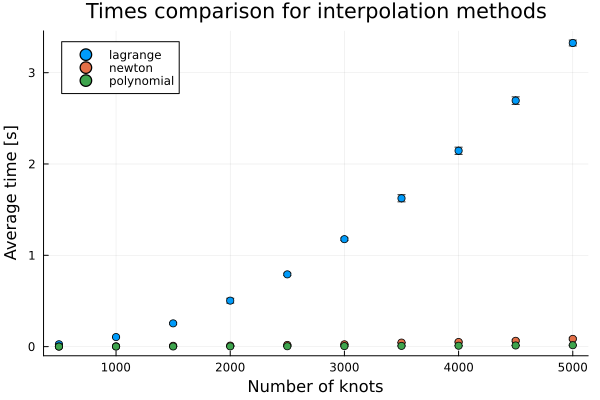

In [146]:
using Statistics
df[!, :total_time] = df[:, :pol_time] .+ df[:, :point_time]

stats = combine(groupby(df, [:type, :points]),
"pol_time" => mean, "pol_time" => std,
"point_time" => mean, "point_time" => std,
"total_time" => mean, "total_time" => std,)

scatter(stats.points, stats.total_time_mean,
group=stats.type, yerr=stats.total_time_std,
xlabel = "Number of knots", ylabel="Average time [s]",
title = "Times comparison for interpolation methods")

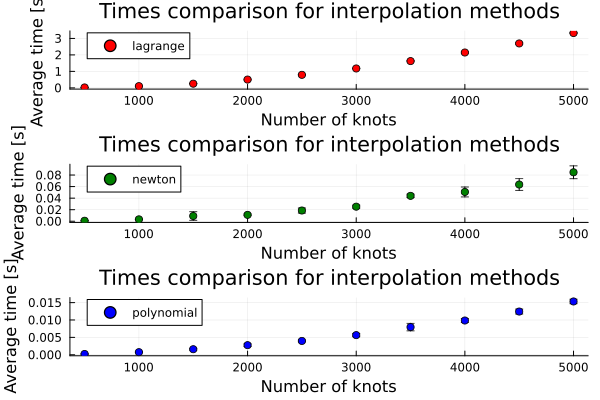

In [147]:
scatter(stats.points, stats.total_time_mean,
group=stats.type, yerr=stats.total_time_std,
xlabel = "Number of knots", ylabel="Average time [s]",
title = "Times comparison for interpolation methods",
layout=(3,1), color=[:red :green :blue])

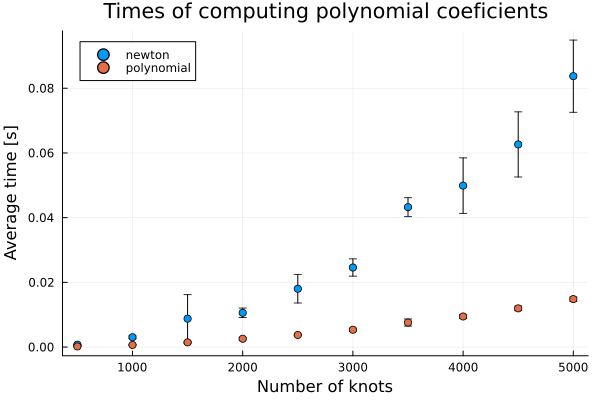

In [148]:
np_stats = filter(row -> row[:type] == "polynomial"
|| row[:type] == "newton", stats)

scatter(np_stats.points, np_stats.pol_time_mean,
group=np_stats.type, yerr=np_stats.pol_time_std,
xlabel = "Number of knots", ylabel="Average time [s]",
title = "Times of computing polynomial coeficients")

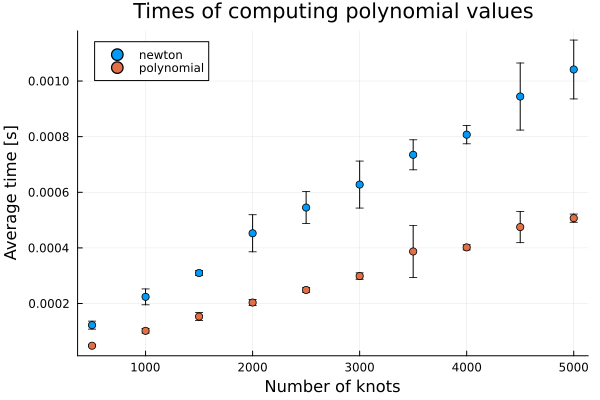

In [149]:
scatter(np_stats.points, np_stats.point_time_mean,
group=np_stats.type, yerr=np_stats.point_time_std,
xlabel = "Number of knots", ylabel="Average time [s]",
title = "Times of computing polynomial values")

5. Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

In [150]:
function NevilleInterpolation(x, y)
    function polynomial(z)
        n = length(x)
        F = zeros(n, n)
        F[:, 1] .= y
        for j in 2:n
            for i in j:n
                F[i, j] = ((z - x[i]) * F[i-1, j-1] -
                (z - x[i-j+1]) * F[i, j-1]) / (x[i-j+1]-x[i])
            end
            
        end
        return F[n, n]
    end
    return polynomial
end


NevilleInterpolation (generic function with 1 method)

In [151]:
test_points = 0:0.2:1
x, y = interpolation_points(10)
p_neville = NevilleInterpolation(x, y)
p_newton = NewtonInterpolation(x, y)
for point in test_points
    println("Value of function in point: ", point)
    v1 = p_neville(point)
    v2 = p_newton(point)
    println("Newton interpolation value:  ", v2)
    println("Neville interpolation value: ", v1)
    println("Difference ", abs(v1 - v2))
    println("")
end

    

Value of function in point: 0.0
Newton interpolation value:  -1535.0122094436667
Neville interpolation value: -1535.012209443668
Difference 1.3642420526593924e-12

Value of function in point: 0.2
Newton interpolation value:  0.919186756368465
Neville interpolation value: 0.9191867563686347
Difference 1.6964207816272392e-13

Value of function in point: 0.4
Newton interpolation value:  0.6735895259196365
Neville interpolation value: 0.673589525919629
Difference 7.549516567451064e-15

Value of function in point: 0.6
Newton interpolation value:  0.9069947757606979
Neville interpolation value: 0.9069947757607062
Difference 8.326672684688674e-15

Value of function in point: 0.8
Newton interpolation value:  1.1858385546092924
Neville interpolation value: 1.185838554609295
Difference 2.6645352591003757e-15

Value of function in point: 1.0
Newton interpolation value:  48.544666410921145
Neville interpolation value: 48.54466641092113
Difference 1.4210854715202004e-14



Rezultaty są takie same, z dokładnością do co najmniej 10 miejsc po przecinku. Różnice wynikają z odmiennych metod obliczania wartości


6. Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>.

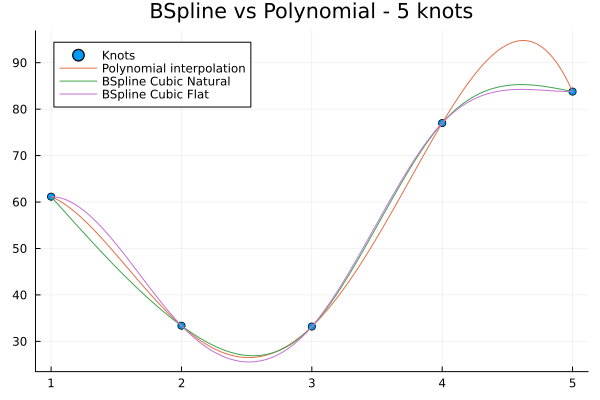

In [152]:
using Interpolations
x_test1 = 1:5
y_test1 = rand(5)*100
scatter(x_test1, y_test1, label="Knots",
title="BSpline vs Polynomial - 5 knots")
z = collect(range(minimum(x_test1), maximum(x_test1), length=1000))

p_pol = fit(x_test1, y_test1)
pol_val = p_pol.(z)
plot!(z, pol_val, label="Polynomial interpolation")

cube = interpolate(y_test1, BSpline(Cubic(Natural(OnGrid()))))
cub_val = cube.(z)
plot!(z, cub_val, label="BSpline Cubic Natural")

cube = interpolate(y_test1, BSpline(Cubic(Flat(OnGrid()))))
cub_val = cube.(z)
plot!(z, cub_val, label="BSpline Cubic Flat")

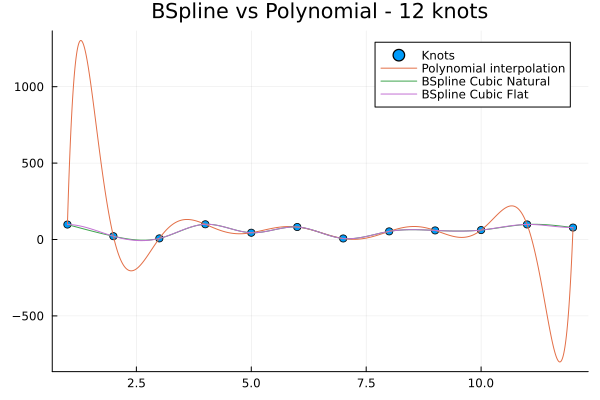

In [153]:
using Interpolations
x_test1 = 1:12
y_test1 = rand(12)*100
scatter(x_test1, y_test1, label="Knots",
title="BSpline vs Polynomial - 12 knots")
z = collect(range(minimum(x_test1), maximum(x_test1), length=1000))

p_pol = fit(x_test1, y_test1)
pol_val = p_pol.(z)
plot!(z, pol_val, label="Polynomial interpolation")

cube = interpolate(y_test1, BSpline(Cubic(Natural(OnGrid()))))
cub_val = cube.(z)
plot!(z, cub_val, label="BSpline Cubic Natural")

cube = interpolate(y_test1, BSpline(Cubic(Flat(OnGrid()))))
cub_val = cube.(z)
plot!(z, cub_val, label="BSpline Cubic Flat")

W tym przypadku widoczny jest efekt rungego